# Physics-informed neural network (PINN) demo


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the boundary conditions of the system
- Outputs: estimate of the solution, $y(x)$

#### Differential Equation with B.C.

$$ \frac{d^2y}{dx^2} - 400*y = 0 $$

$$ y(0) = 300 $$





#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(x;\theta) \approx y(x)~,
$$


#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= \lambda_1(N\!N(0;\theta) - 0)^2 +  \frac{\lambda_2}{N} \sum^{N}_{i} \left( \frac{dN\!N(t_{i};\theta)}{dx} - x \right)^2
$$

#### Computing gradients

To compute gradients of the neural network with respect to its inputs, we will use `torch.autograd.grad`

## Initial setup

First, we define a few helper functions.

In [3]:
def exact_solution(x):
    u = ((np.cos(1-x)+2*np.cos(x))/np.sin(1)) + x**2 -2
    return u

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

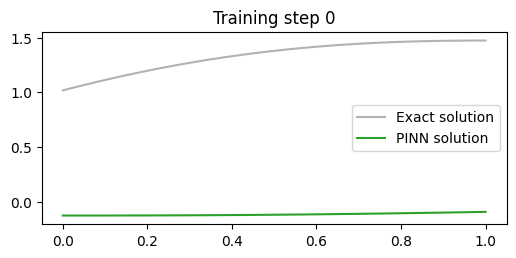

Epoch [1/1000], Loss: 1.1308
BC1 LOSS 1.0239535570144653
BC2 LOSS 0.003918301314115524
PDE LOSS 0.22946049273014069


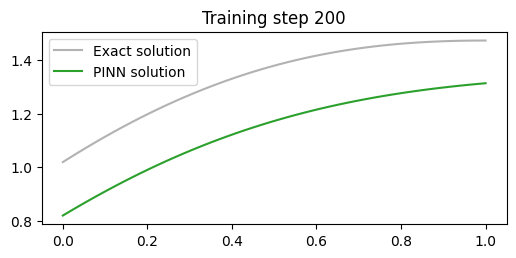

Epoch [201/1000], Loss: 0.0180
BC1 LOSS 0.0032934723421931267
BC2 LOSS 0.01932157203555107
PDE LOSS 0.0016979128122329712


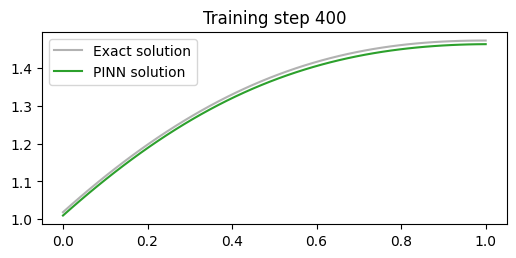

Epoch [401/1000], Loss: 0.0010
BC1 LOSS 1.9863227862515487e-05
BC2 LOSS 3.6044439184479415e-05
PDE LOSS 0.001062088063918054


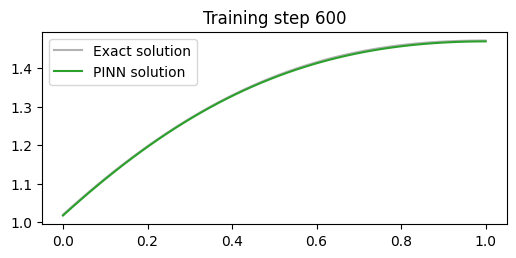

Epoch [601/1000], Loss: 0.0008
BC1 LOSS 2.172743506889674e-06
BC2 LOSS 2.415851668047253e-06
PDE LOSS 0.0009242432424798608


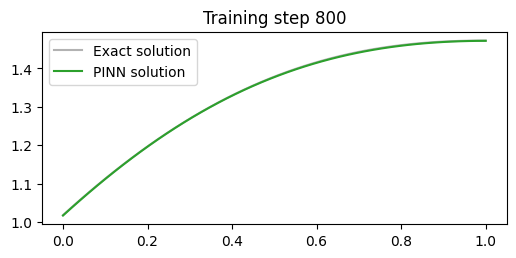

Epoch [801/1000], Loss: 0.0007
BC1 LOSS 5.480288223225216e-07
BC2 LOSS 5.582884909927088e-07
PDE LOSS 0.000822398578748107


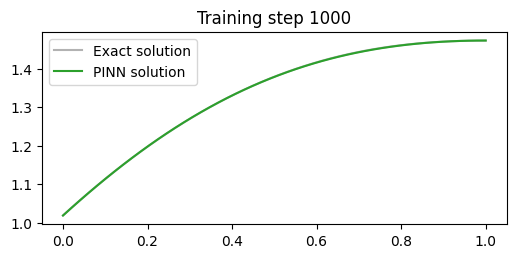

Epoch [1001/1000], Loss: 0.0007
BC1 LOSS 6.710264699449908e-08
BC2 LOSS 4.9505604948762993e-08
PDE LOSS 0.0007479669293388724


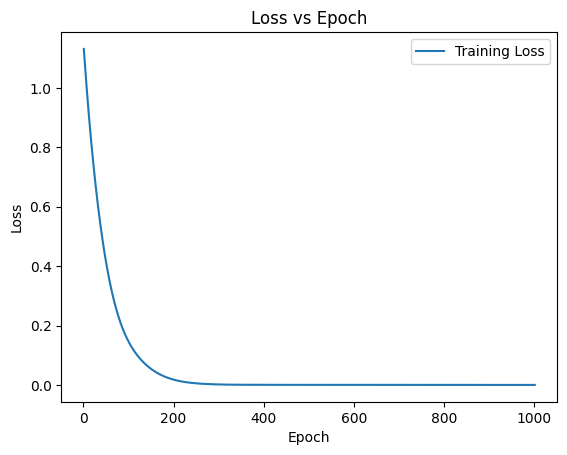

In [4]:
# define a neural network to train
pinn = FCN(1, 1, 64,3)

# define boundary points, for the boundary loss
x_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)# (1, 1)
x_boundary2 = torch.tensor(1.0).view(-1,1).requires_grad_(True)# (1, 1)
# x_boundary3 = torch.tensor(3.0).view(-1,1).requires_grad_(True)# (1, 1)

# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(0, 1,200).view(-1,1).requires_grad_(True)# (20, 1)

x_test = torch.linspace(0,1,50).view(-1,1) #(200, 1)

u_exact = exact_solution(x_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-4)
num_epochs = 1000
losses = []
for i in range(num_epochs+1):
    optimiser.zero_grad()

    # using the following hyperparameters
    lambda1, lambda2 = 0.9, 0.7

    # compute boundary loss
    u = pinn(x_boundary)# (1, 1)
    dudx = torch.autograd.grad(u, x_boundary, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss1 = torch.mean((dudx-1)**2)

    u2 = pinn(x_boundary2)
    dudx = torch.autograd.grad(u2, x_boundary2, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss2 = torch.mean((dudx)**2)

    # compute physics loss
    u = pinn(x_physics)  # (20, 1)
    dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    dudx2 = torch.autograd.grad(dudx, x_physics, torch.ones_like(u), create_graph=True)[0]  # (20, 1)
    loss3 = torch.mean((dudx2 + u -x_physics**2)**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda1* loss1 + lambda2* loss2 + lambda1*loss3
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

    # plot the result as training progresses
    if i % 200 == 0:
        u = pinn(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
        print(f"Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}")
        print(f'BC1 LOSS {loss1}')
        print(f'BC2 LOSS {loss2}')
        print(f'PDE LOSS {loss3}')


plt.plot(range(1, num_epochs+2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

Avg Percentage Error (excluding infinite values) is: 0.008623010516166686
Maximum Percentage Error (excluding infinite values) is: [0.010834197513759136]


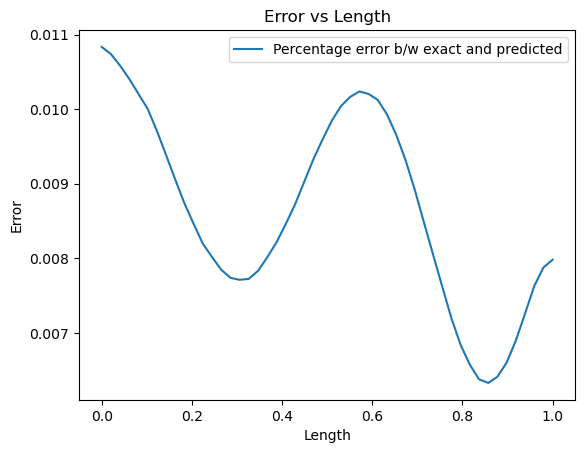

In [ ]:
# Calculate error
diff = abs(u_exact - u) / abs(0.01 * u_exact)

# Mask out infinite values
masked_diff = np.ma.masked_invalid(diff)
max_error = max(masked_diff)

# Calculate mean excluding infinite values
mean_error = np.mean(masked_diff)

print(f'Avg Percentage Error (excluding infinite values) is: {mean_error}')
print(f'Maximum Percentage Error (excluding infinite values) is: {max_error}')

# Plot
plt.plot(x_test, diff, label='Percentage error b/w exact and predicted')
plt.xlabel('Length')
plt.ylabel('Error')
plt.title('Error vs Length')
plt.legend()
plt.show()


Overall RMSE is: 0.0004139066440984607


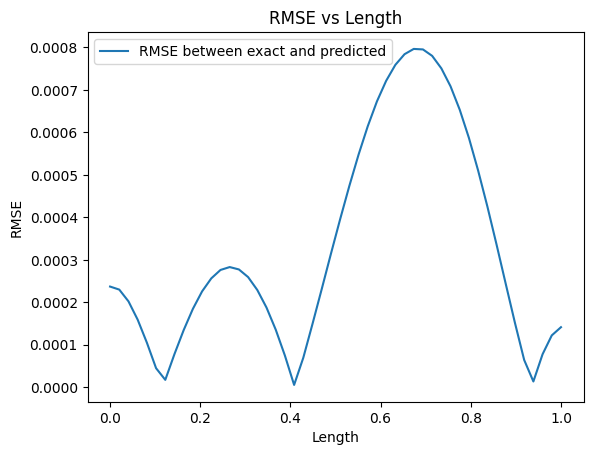

In [5]:
# Assuming u_exact and u are NumPy arrays
u_exact2 = u_exact.numpy()
u2 = u.numpy()

# Calculate RMSE at each point
rmse_per_point = np.sqrt(np.mean((u_exact2 - u2)**2, axis=1))
overall_rmse = np.sqrt(np.mean((u_exact2 - u2)**2))
print(f'Overall RMSE is: {overall_rmse}')

# Plot the RMSE at each point
plt.plot(x_test, rmse_per_point, label='RMSE between exact and predicted')
plt.xlabel('Length')
plt.ylabel('RMSE')
plt.title('RMSE vs Length')
plt.legend()
plt.show()
